In [1]:
!pip install pystan==2.19.1.1
!pip install prophet

In [1]:
import os
import glob
import csv
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

import random
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
import datetime

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

In [3]:
def interpolate_method(df,column_name,methode,direction,order,limit):
    df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
    return df

def clean_csv(df,time_variable,quantitative_variable):
    df = df[[time_variable, quantitative_variable]].copy()
    df.columns = ['ds','y']
    df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
    df = df.drop_duplicates(subset=['ds'])
    df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
    df = df.dropna(subset=['ds'])
    df = df.sort_values(by=['ds'])
    pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
    #if (pourcentage <= 2):
    #  df = df.dropna(subset=['y'])

    if(pourcentage < 25):
        df = interpolate_method(df,'y',"polynomial",None,2,None)
    elif((pourcentage >= 25)):
        print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
    if(len(df) > 1000):
        supr = len(df) - 1000
        df = df[:-supr]
    return df, pourcentage

In [4]:
def naive_method(df):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
      print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 300
    train_len = n-period
    train = df[0:train_len]
    val = df[train_len:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train_scaled = TimeSeries.from_dataframe(train, 'ds', 'y')
    val_scaled = TimeSeries.from_dataframe(val, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train_scaled)
    val_scaled = scaler.transform(val_scaled)
    series_scaled = scaler.transform(series)
        
    y_hat_naive = val.copy()
    y_hat_naive['naive_forecast'] = train['y'][train_len-1]
    
    y_hat_naive_scaled = TimeSeries.from_dataframe(y_hat_naive, 'ds', 'naive_forecast')
    y_hat_naive_scaled = scaler.transform(y_hat_naive_scaled)
    
    MAE = mae(val_scaled,y_hat_naive_scaled)
    MSE = mse(val_scaled,y_hat_naive_scaled)
    RMSE = rmse(val_scaled,y_hat_naive_scaled)


    return(train_scaled, val_scaled, y_hat_naive_scaled, MAE, MSE, RMSE)

In [5]:
def prophet_model(df,frequency):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
    print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 300
    df_fit = df[:-period]
    df_true = df[n-period:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train = TimeSeries.from_dataframe(df_fit, 'ds', 'y')
    val = TimeSeries.from_dataframe(df_true, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    series_scaled = scaler.transform(series)
    
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality = True)
    m.fit(df_fit)
    future = m.make_future_dataframe(periods=period*2, freq=frequency)
    if (frequency == 'M'):
        for i in range (n-period, len(future)):
            future['ds'][i] = future['ds'][i] + datetime.timedelta(days=1)
    forecast = m.predict(future)
    df_true_prediction = pd.merge(df_true, forecast, how ='inner', on =['ds'])
    df_true_prediction = df_true_prediction[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
    
    pred = TimeSeries.from_dataframe(df_true_prediction, 'ds', 'yhat')
    pred_scaled = scaler.transform(pred)
    
    MAE = mae(val_scaled,pred_scaled)
    MSE = mse(val_scaled,pred_scaled)
    RMSE = rmse(val_scaled, pred_scaled)
    
    return(train_scaled, val_scaled, pred_scaled, MAE, MSE, RMSE)

In [6]:
os.getcwd()

'/home/nazim/MAIN4/Transformers/Code/700-300'

In [7]:
os.chdir('../../Datasets/Climat')
os.getcwd()

'/home/nazim/MAIN4/Transformers/Datasets/Climat'

In [8]:
!ls

M-data_Afghanistan.csv	    M-data_Benin.csv
M-data_Albania.csv	    M-data_Bolivia.csv
M-data_Algeria.csv	    M-data_Bosnia_H.csv
M-data_Andorra.csv	    M-data_Botswana.csv
M-data_Antigua_Barbada.csv  M-data_British_Virgin_Island.csv
M-data_Armenia.csv	    M-data_Burma.csv
M-data_Azerbaijan.csv	    M-data_Cameroon.csv
M-data_Bahamas.csv	    M-data_Colombia.csv
M-data_Baker_Island.csv     M-data_Costa_Rica.csv
M-data_Belgium.csv


In [9]:
def predict():
    file_name = []
    df = []
    pourcentage = []

    df_fit_naive = []
    df_true_prediction_naive = []
    forecast_naive = []

    df_fit_prophet = []
    df_true_prediction_prophet = []
    forecast_prophet = []

    results_naive = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
    results_prophet = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])

    i = 0
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files)
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "Date","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)
        
        df_fit_temp_naive , df_true_prediction_temp_naive , forecast_temp_naive , MAE_naive, MSE_naive, RMSE_naive = naive_method(df[i])
        df_fit_naive.append(df_fit_temp_naive)
        df_true_prediction_naive.append(df_true_prediction_temp_naive)
        forecast_naive.append(forecast_temp_naive)

        df_fit_temp_prophet , df_true_prediction_temp_prophet , forecast_temp_prophet , MAE_prophet, MSE_prophet, RMSE_prophet = prophet_model(df[i],file_name[i][0])
        df_fit_prophet.append(df_fit_temp_prophet)
        df_true_prediction_prophet.append(df_true_prediction_temp_prophet)
        forecast_prophet.append(forecast_temp_prophet)

        df_new_row_naive = pd.DataFrame(data=np.array([[file_name[i],'Naive Method',MAE_naive,MSE_naive,RMSE_naive]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        df_new_row_prophet = pd.DataFrame(data=np.array([[file_name[i],'Prophet Method',MAE_prophet,MSE_prophet,RMSE_prophet]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        results_naive = pd.concat([results_naive,df_new_row_naive], ignore_index=True)
        results_prophet = pd.concat([results_prophet,df_new_row_prophet], ignore_index=True)
        i = i +1

    return file_name,df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet

In [10]:
file_name, df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet = predict()

M-data_Bahamas
Initial log joint probability = -5.59039
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2326.47   0.000894794       192.003      0.9272      0.9272      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2327.6   0.000115403       81.0013           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       2327.67    2.0931e-05       107.681   1.504e-07       0.001      320  LS failed, Hessian reset 
     269       2327.71   1.15587e-07       62.0817      0.4134           1      386   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
M-data_British_Virgin_Island
Initial log joint probability = -3.09425
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2753.63   0.0

M-data_Azerbaijan
Initial log joint probability = -61.5844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1707.64    0.00212024       272.908      0.3538      0.3538      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       1709.11   0.000190892       134.718   2.642e-06       0.001      185  LS failed, Hessian reset 
     187        1713.8   0.000166314       120.893    7.17e-07       0.001      325  LS failed, Hessian reset 
     199       1714.52    0.00053159       124.489      0.8469      0.8469      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274       1715.99   0.000269779       220.773   2.324e-06       0.001      500  LS failed, Hessian reset 
     299        1717.2    0.00107359       145.605           1           1      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alp

M-data_Costa_Rica
Initial log joint probability = -2.37255
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2553.23    0.00114754       216.749           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2554.17   0.000492468       189.051       5.479      0.5479      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       2554.33   1.13603e-05       93.6755   6.462e-08       0.001      405  LS failed, Hessian reset 
     299       2554.36   9.06554e-06        65.026           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     366       2554.41   4.69409e-09       64.7493    0.001555           1      542   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
M-data_Be

In [11]:
df

[            ds       y
 0   1887-05-01  24.758
 1   1887-06-01  26.902
 2   1887-07-01  28.106
 3   1887-08-01  27.844
 4   1887-09-01  26.937
 ..         ...     ...
 995 1970-04-01  25.273
 996 1970-05-01  25.619
 997 1970-06-01  27.377
 998 1970-07-01  28.384
 999 1970-08-01  28.719
 
 [1000 rows x 2 columns],
             ds       y
 0   1883-02-01  24.152
 1   1883-03-01  23.994
 2   1883-04-01  24.571
 3   1883-05-01  25.696
 4   1883-06-01  26.860
 ..         ...     ...
 995 1966-01-01  24.878
 996 1966-02-01  24.859
 997 1966-03-01  25.302
 998 1966-04-01  25.736
 999 1966-05-01  26.542
 
 [1000 rows x 2 columns],
             ds       y
 0   1871-01-01  21.704
 1   1871-02-01  21.119
 2   1871-03-01  21.750
 3   1871-04-01  20.687
 4   1871-05-01  18.368
 ..         ...     ...
 995 1953-12-01  22.932
 996 1954-01-01  22.203
 997 1954-02-01  22.008
 998 1954-03-01  21.475
 999 1954-04-01  21.126
 
 [1000 rows x 2 columns],
             ds       y
 0   1801-05-01  17.825
 1  

In [12]:
results_naive

DATA_SET_NAME        Method                  MAE  \
0                 M-data_Bahamas  Naive Method  0.31648229615468976   
1   M-data_British_Virgin_Island  Naive Method  0.20898919244260303   
2                 M-data_Bolivia  Naive Method  0.19683763460725007   
3                 M-data_Albania  Naive Method  0.43788852596330874   
4            M-data_Baker_Island  Naive Method  0.04018071088280242   
5                 M-data_Algeria  Naive Method  0.32053764697135984   
6                 M-data_Andorra  Naive Method  0.23604340946227173   
7              M-data_Azerbaijan  Naive Method  0.25933763725762105   
8                 M-data_Belgium  Naive Method   0.2475194299206545   
9                   M-data_Burma  Naive Method  0.21257554077992963   
10            M-data_Afghanistan  Naive Method   0.4259777262935414   
11               M-data_Cameroon  Naive Method  0.16500166129813884   
12                M-data_Armenia  Naive Method    0.249129238038633   
13             M-data_Costa_Rica  Naive Method  0.12510507717310929   
14                  M-data_Benin  Naive Method  0.23089189632060642   
15               M-data_Bosnia_H  Naive Method  0.12494150956155442   
16               M-data_Botswana  Naive Method  0.49321658566381044   
17        M-data_Antigua_Barbada  Naive Method  0.22776123945823665   
18               M-data_Colombia  Naive Method   0.1565758218510646   

                     MSE                 RMSE  
0    0.16128287621040174   0.4016003936880562  
1    0.06068846705471566  0.24635029339279396  
2   0.052347157124890714  0.22879501114510936  
3     0.2691729073523708   0.5188187615655112  
4   0.002813404514041492  0.05304153574361787  
5     0.1523146857064441   0.3902751410305864  
6    0.08200121762210519  0.28635854731805227  
7    0.09226419418563181  0.30375021676639474  
8    0.09409716671880827  0.30675261485243815  
9    0.08038399723122522   0.2835207174638658  
10   0.25559549979364293   0.5055645357356892  
11   0.04675637585864634  0.21623222668845257  
12   0.08008924611183633   0.2830004348262319  
13  0.023317260094079608  0.15269990207619522  
14   0.09175908359260788  0.30291761849157584  
15   0.02359399949152482   0.1536033837242032  
16   0.30768814189659416   0.5546964412150074  
17   0.06492270537647596  0.25479934335958554  
18  0.036218791329007585   0.1903123520137555

In [13]:
results_prophet

DATA_SET_NAME          Method                   MAE  \
0                 M-data_Bahamas  Prophet Method   0.05455901359849212   
1   M-data_British_Virgin_Island  Prophet Method  0.058928871365746524   
2                 M-data_Bolivia  Prophet Method  0.061745034632425755   
3                 M-data_Albania  Prophet Method  0.042773285454066175   
4            M-data_Baker_Island  Prophet Method   0.05859823278964445   
5                 M-data_Algeria  Prophet Method  0.030198748530349383   
6                 M-data_Andorra  Prophet Method   0.04446984202952286   
7              M-data_Azerbaijan  Prophet Method   0.03872627320810667   
8                 M-data_Belgium  Prophet Method   0.05125772924426067   
9                   M-data_Burma  Prophet Method   0.04252011789073202   
10            M-data_Afghanistan  Prophet Method    0.0338312624826154   
11               M-data_Cameroon  Prophet Method    0.0687547600513026   
12                M-data_Armenia  Prophet Method   0.03884955675087911   
13             M-data_Costa_Rica  Prophet Method   0.07247079555016844   
14                  M-data_Benin  Prophet Method  0.052397486672383795   
15               M-data_Bosnia_H  Prophet Method  0.022844041702910746   
16               M-data_Botswana  Prophet Method   0.07268885467312947   
17        M-data_Antigua_Barbada  Prophet Method   0.06374065268558458   
18               M-data_Colombia  Prophet Method    0.1633735501321392   

                      MSE                  RMSE  
0      0.0056682474619097   0.07528776435722939  
1    0.005785460610826336   0.07606221539520353  
2    0.006748774391163461   0.08215092446931721  
3   0.0028844631575301403  0.053707198377220725  
4    0.005200660993154524    0.0721156085265494  
5   0.0014658139405493542  0.038285949649308086  
6   0.0031309889502692187   0.05595524059700949  
7   0.0023014684902192186   0.04797362285901721  
8   0.0043998275241770345   0.06633119570893498  
9    0.003183356231855063   0.05642123919106229  
10  0.0020147980167960194   0.04488650149873589  
11   0.008037351487678202   0.08965127711125036  
12  0.0024036942403571873   0.04902748454037987  
13    0.00823727479932647   0.09075943366574336  
14   0.004499809959024887   0.06708062282824219  
15  0.0008525219303469583   0.02919797818937055  
16   0.007779203502578169   0.08819979309827303  
17   0.006615742875141544   0.08133721703587814  
18   0.039148434736397945    0.1978596339236428

In [14]:
results_prophet.to_csv(r'../../Resultats/Resultats_300/prophet_results_climat.csv', index = False)
results_naive.to_csv(r'../../Resultats/Resultats_300/naive_results_climat.csv', index = False)

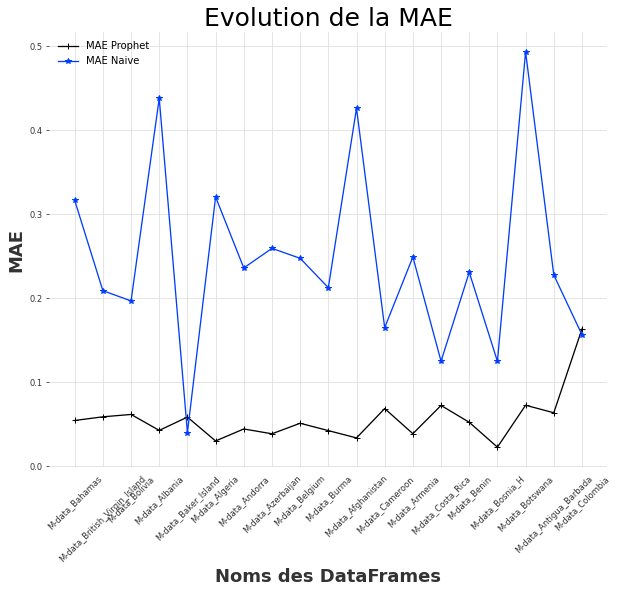

In [15]:
figure(figsize=(10, 8))
plt.axes()

liste_MAE1_prophet = results_prophet["MAE"].tolist()
liste_MAE_prophet = [float(item) for item in liste_MAE1_prophet]

liste_MAE1_naive = results_naive["MAE"].tolist()
liste_MAE_naive = [float(item) for item in liste_MAE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
y = np.array(liste_MAE_prophet)
y2 = np.array(liste_MAE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MAE Prophet', marker="+")
plt.plot(x, y2, label = 'MAE Naive', marker="*")
plt.title("Evolution de la MAE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MAE",fontsize=18)
plt.legend()
plt.show()

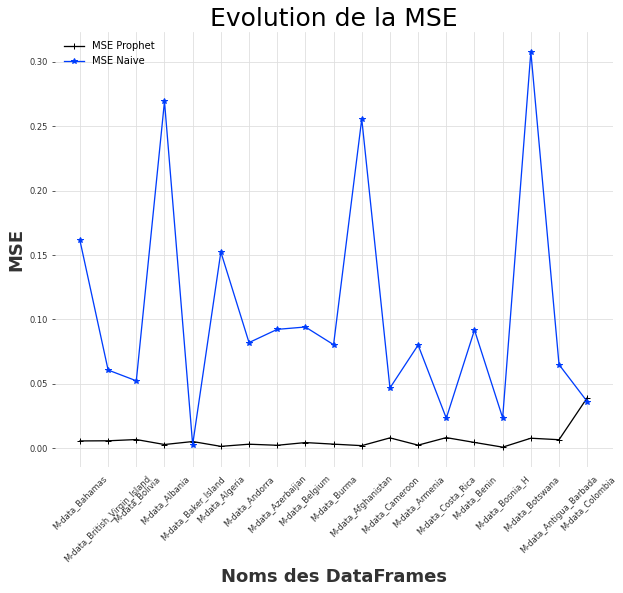

In [16]:
figure(figsize=(10, 8))
plt.axes()

liste_MSE1_prophet = results_prophet["MSE"].tolist()
liste_MSE_prophet = [float(item) for item in liste_MSE1_prophet]

liste_MSE1_naive = results_naive["MSE"].tolist()
liste_MSE_naive = [float(item) for item in liste_MSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
y = np.array(liste_MSE_prophet)
y2 = np.array(liste_MSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MSE Prophet', marker="+")
plt.plot(x, y2, label = 'MSE Naive', marker="*")
plt.title("Evolution de la MSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MSE",fontsize=18)
plt.legend()
plt.show()

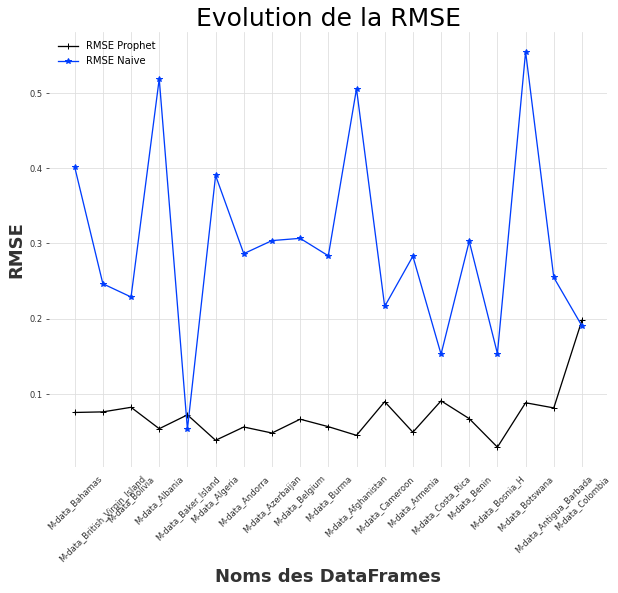

In [17]:
figure(figsize=(10, 8))
plt.axes()

liste_RMSE1_prophet = results_prophet["RMSE"].tolist()
liste_RMSE_prophet = [float(item) for item in liste_RMSE1_prophet]

liste_RMSE1_naive = results_naive["RMSE"].tolist()
liste_RMSE_naive = [float(item) for item in liste_RMSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
y = np.array(liste_RMSE_prophet)
y2 = np.array(liste_RMSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'RMSE Prophet', marker="+")
plt.plot(x, y2, label = 'RMSE Naive', marker="*")
plt.title("Evolution de la RMSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.legend()
plt.show()

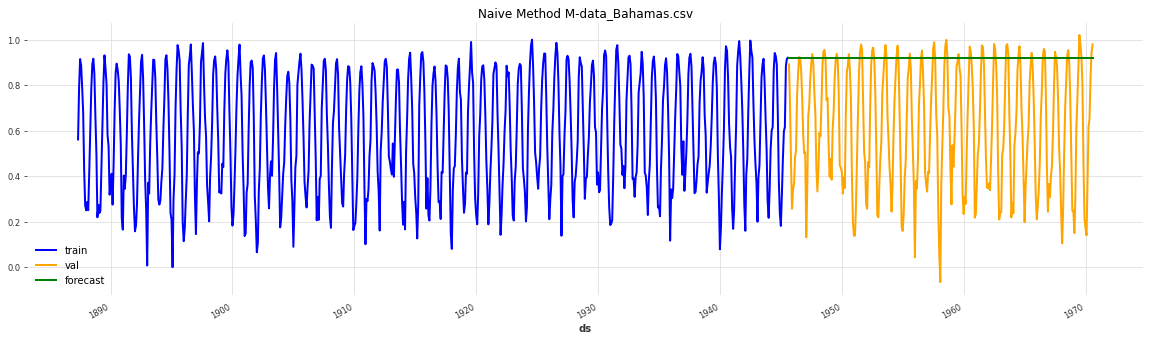

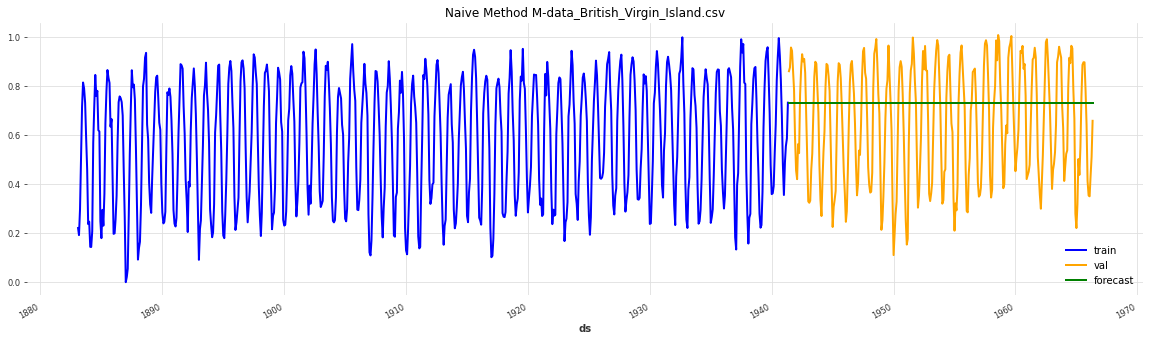

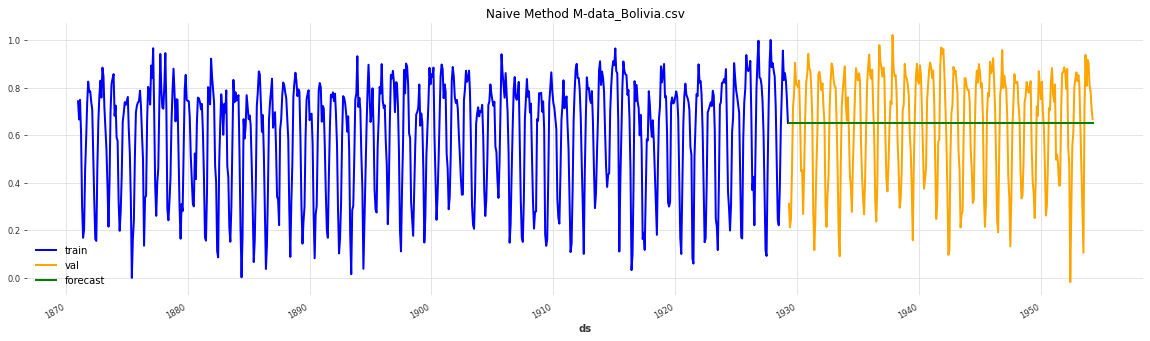

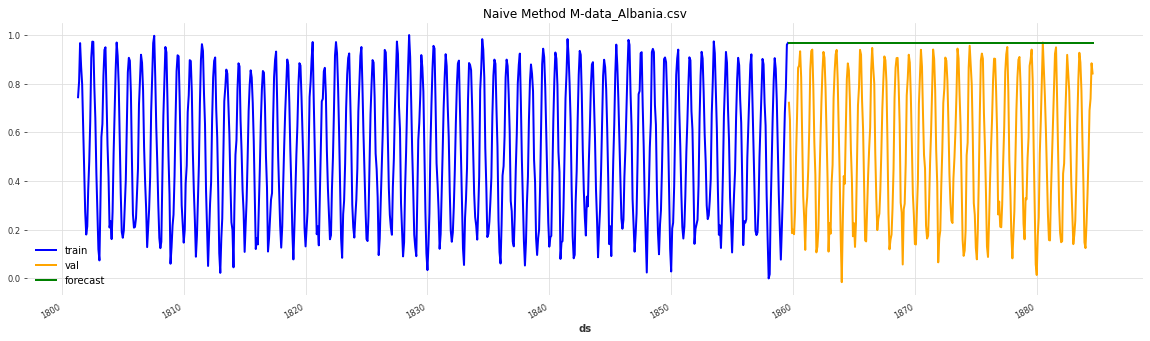

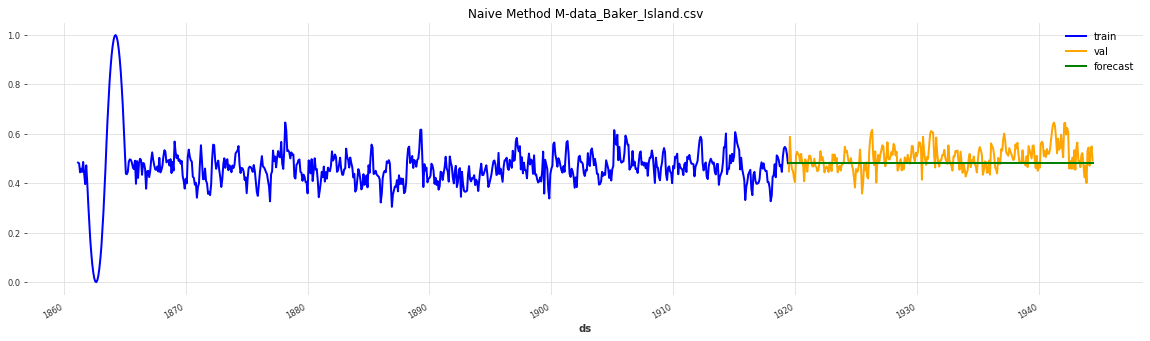

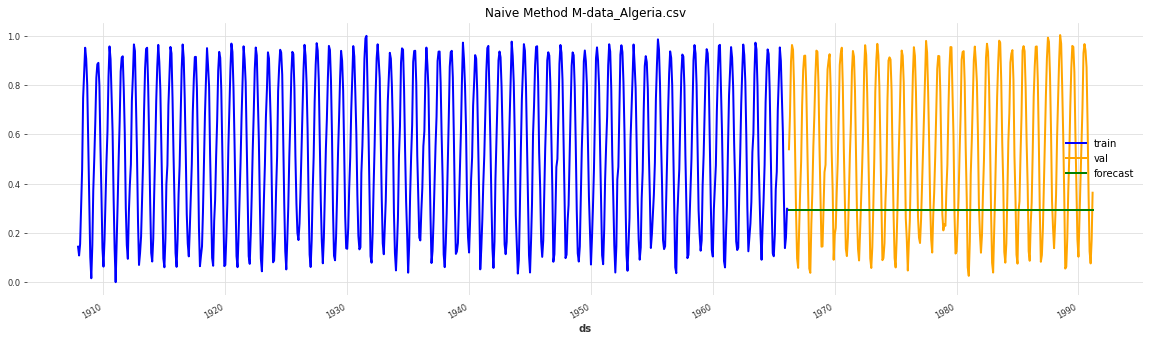

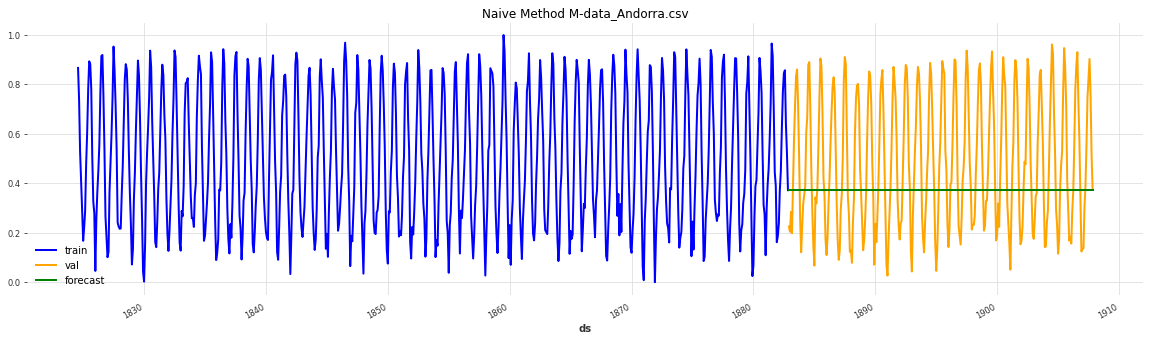

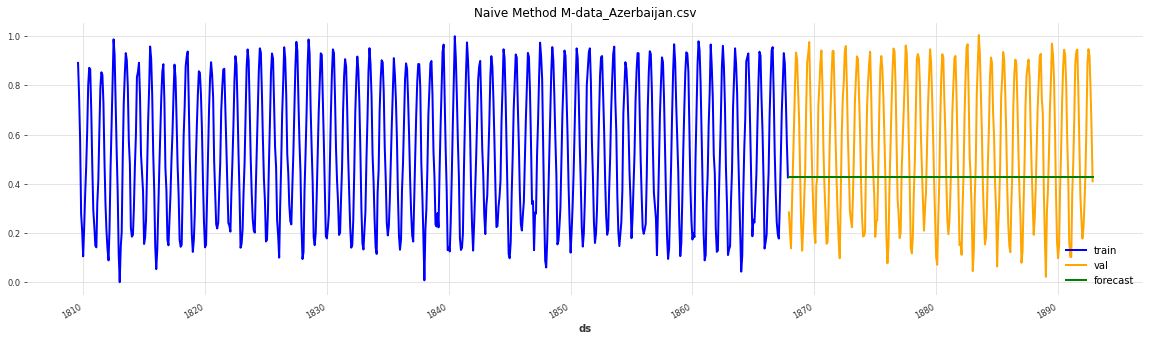

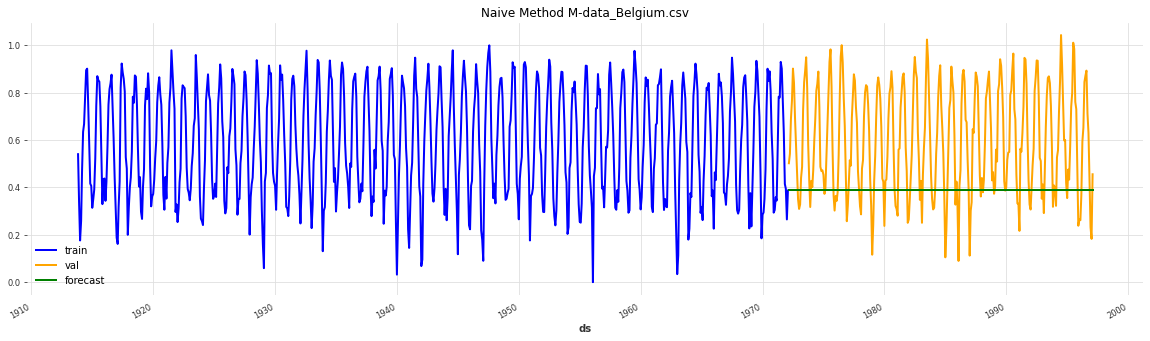

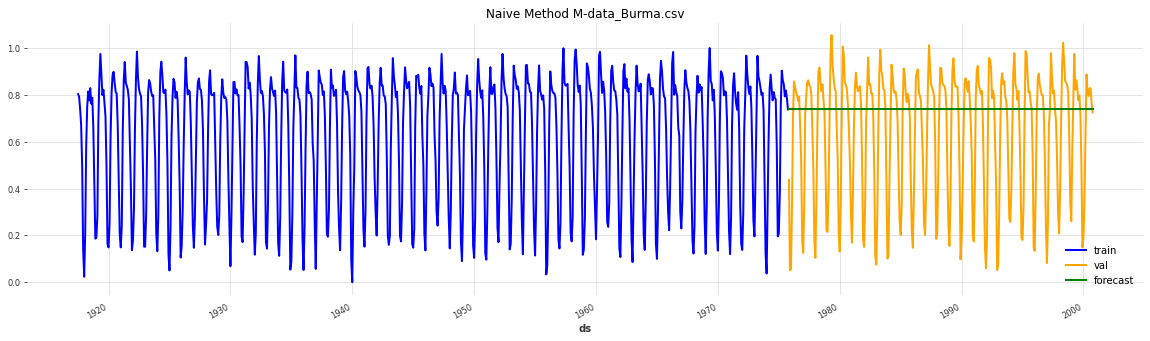

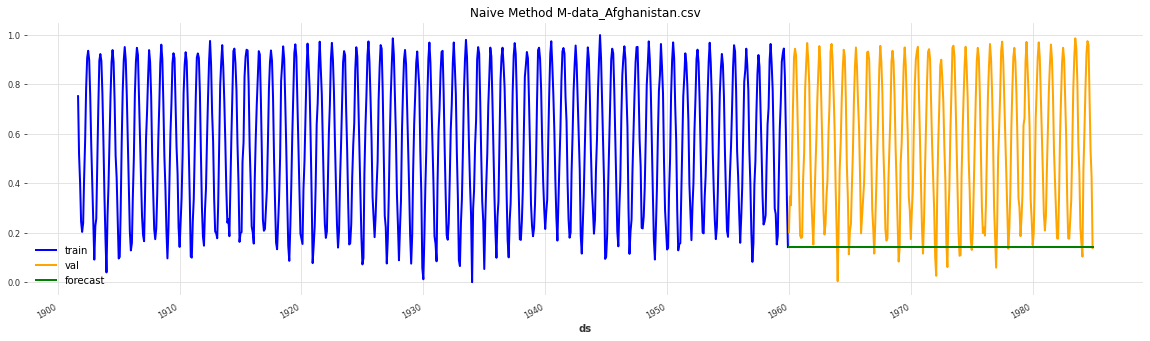

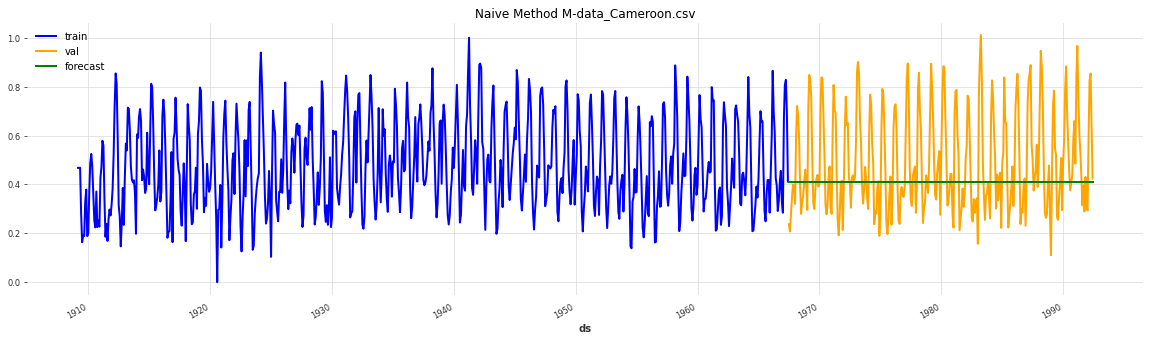

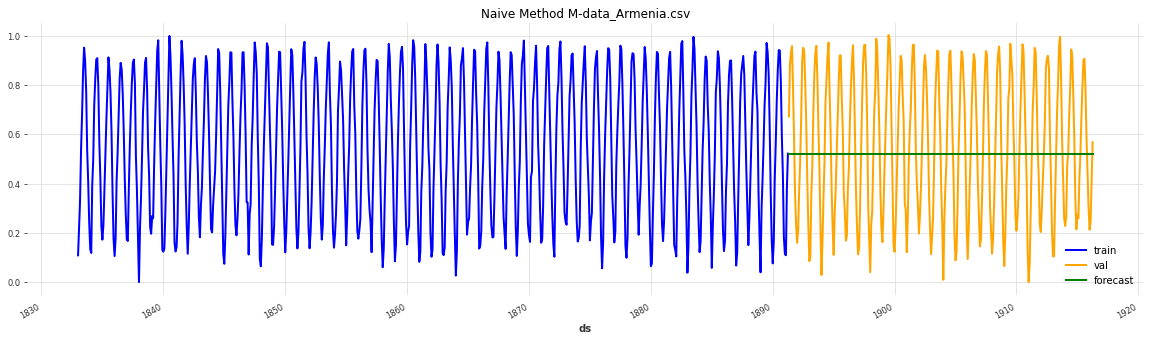

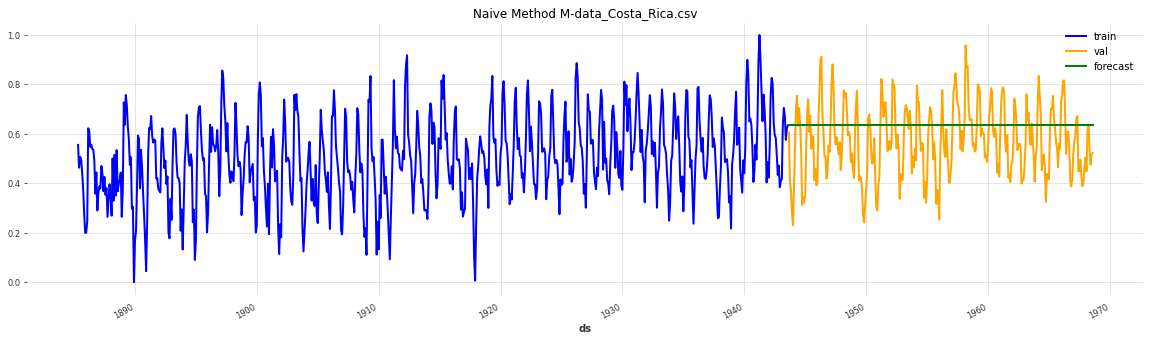

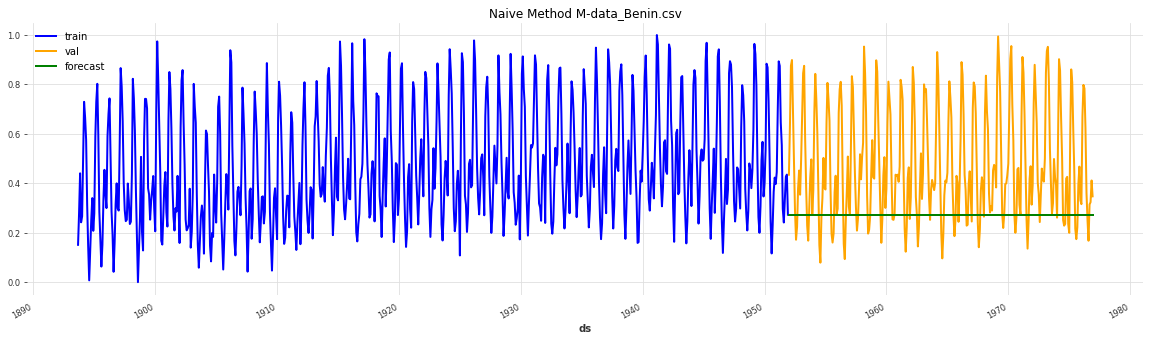

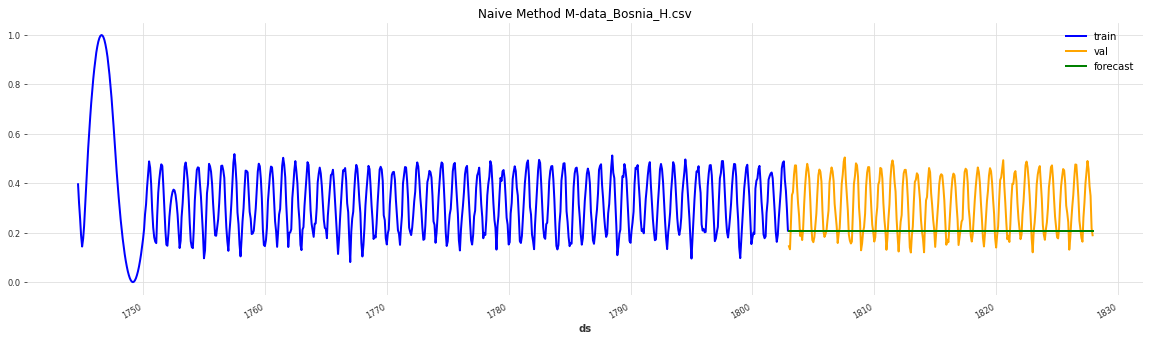

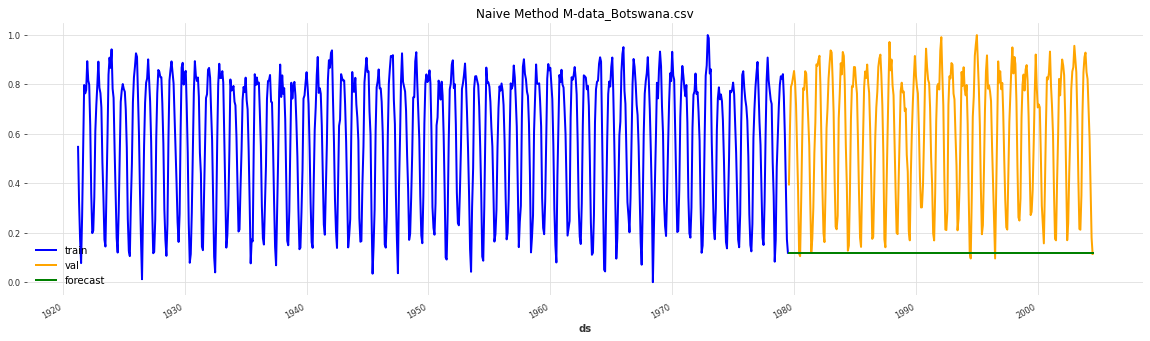

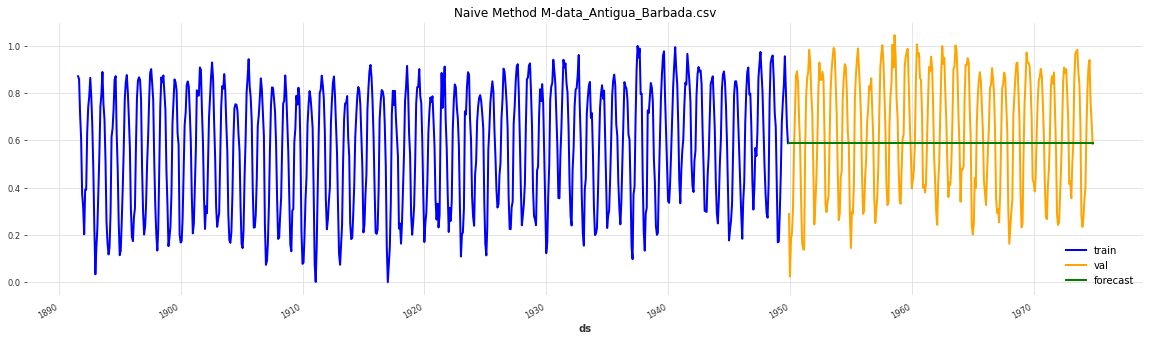

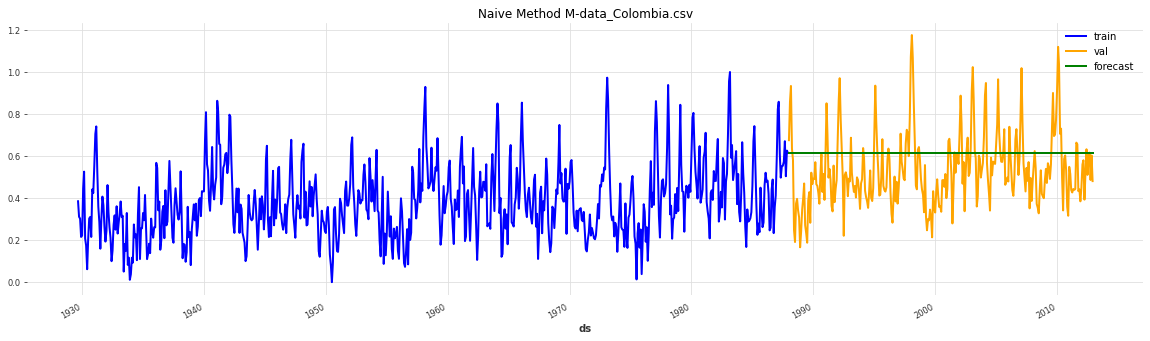

In [18]:
for i in range(len(df_fit_naive)):
    plt.figure(figsize=(20,5))
    df_fit_naive[i].plot(color ='blue', label="train")
    df_true_prediction_naive[i].plot(color ='orange', label="val")
    forecast_naive[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

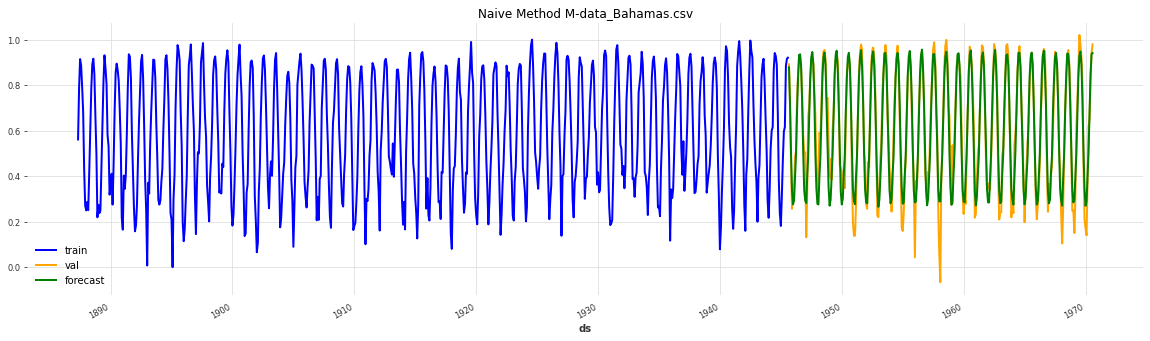

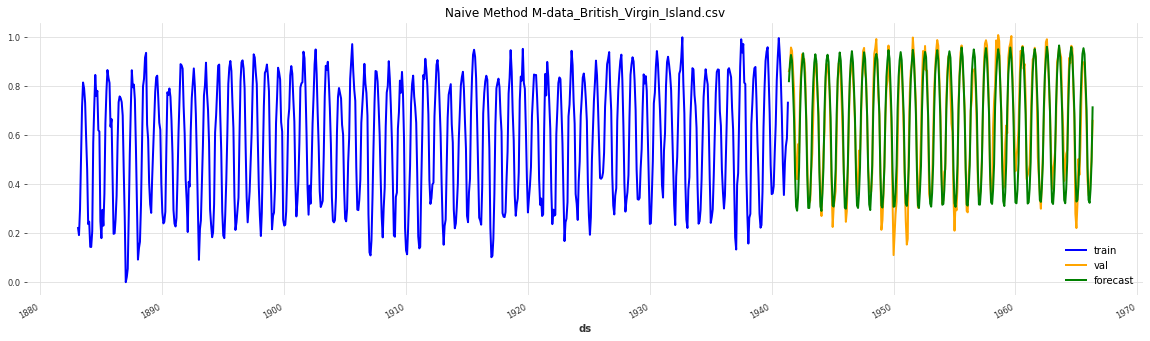

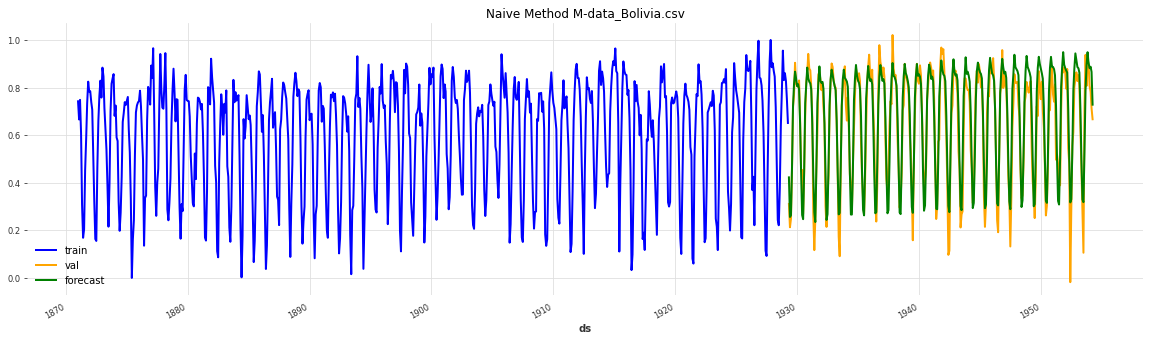

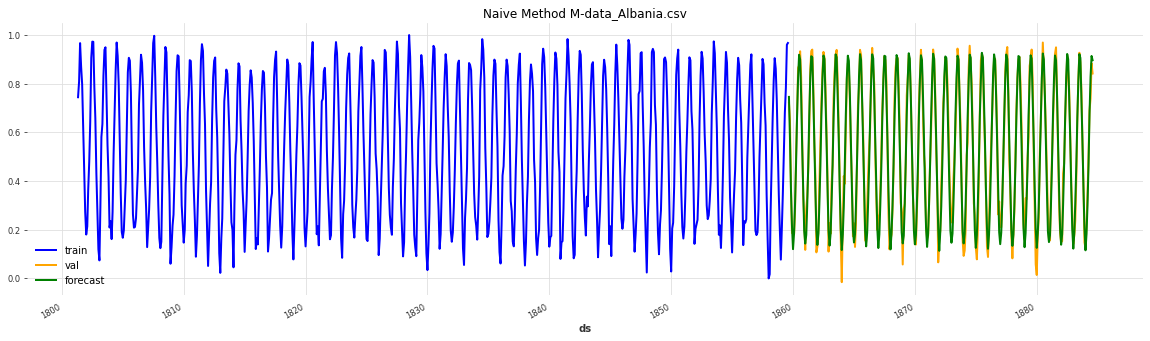

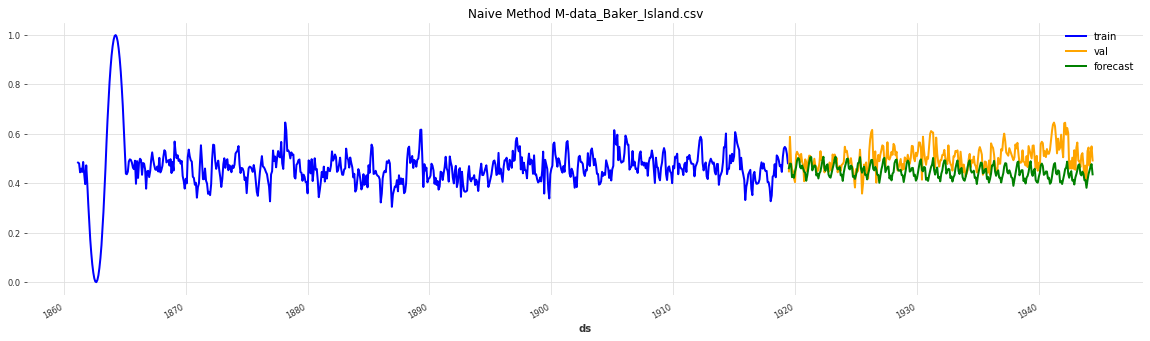

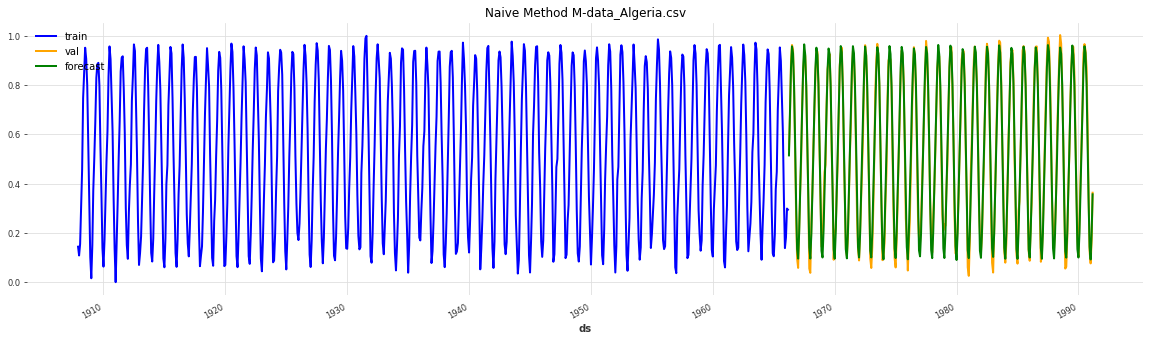

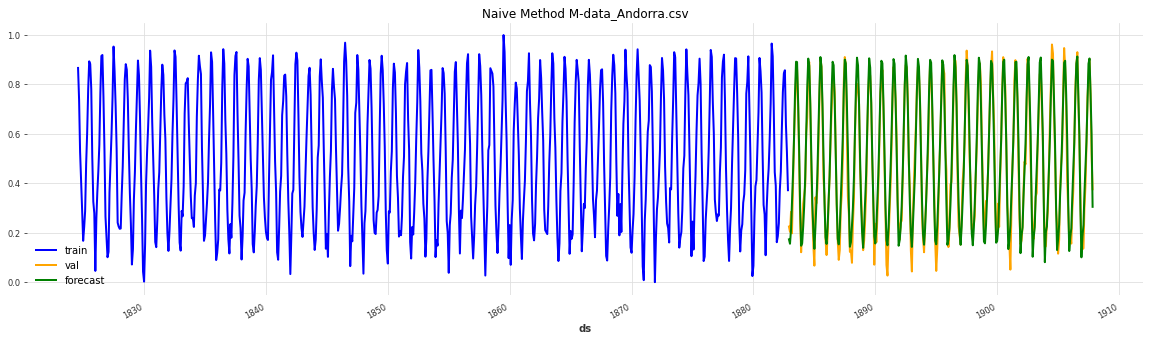

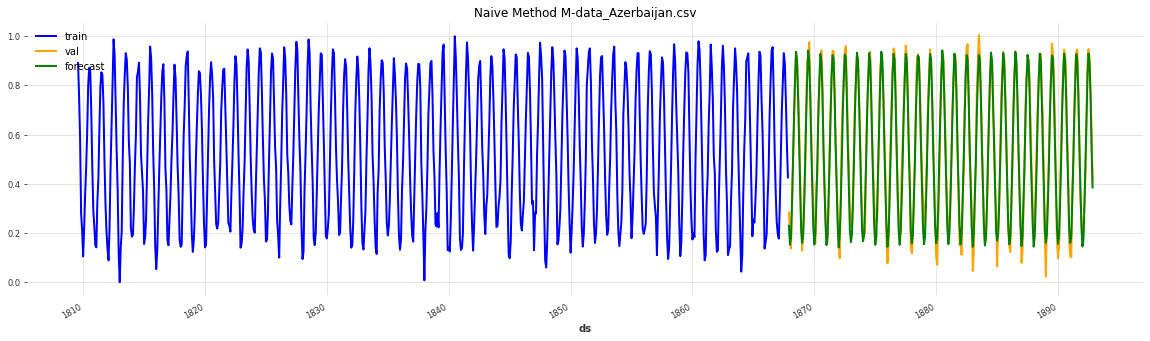

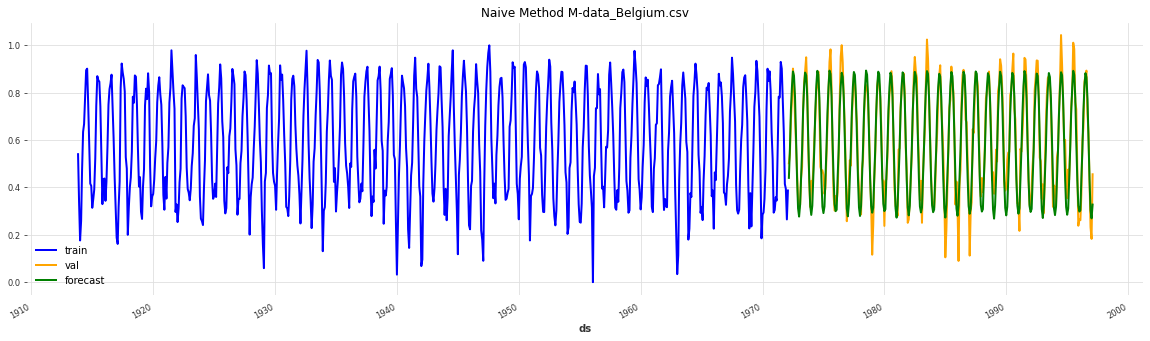

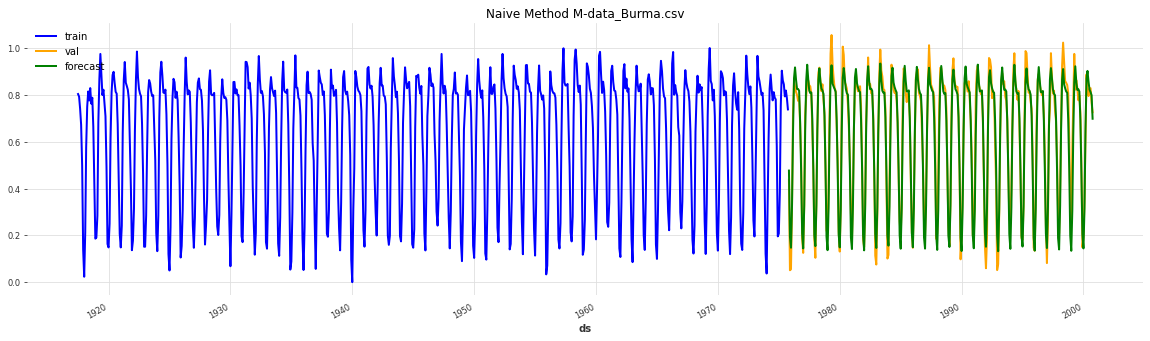

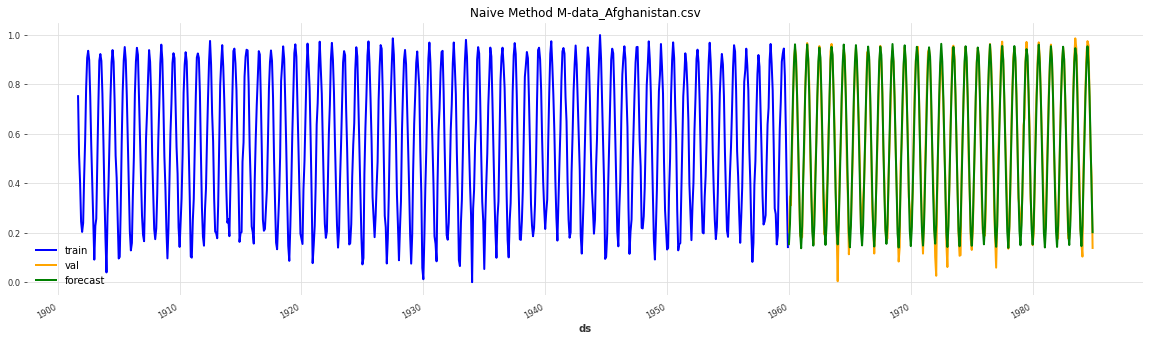

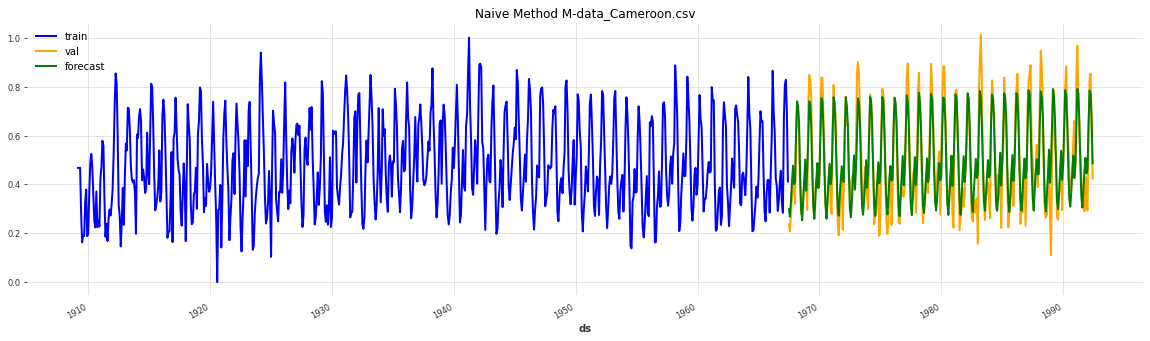

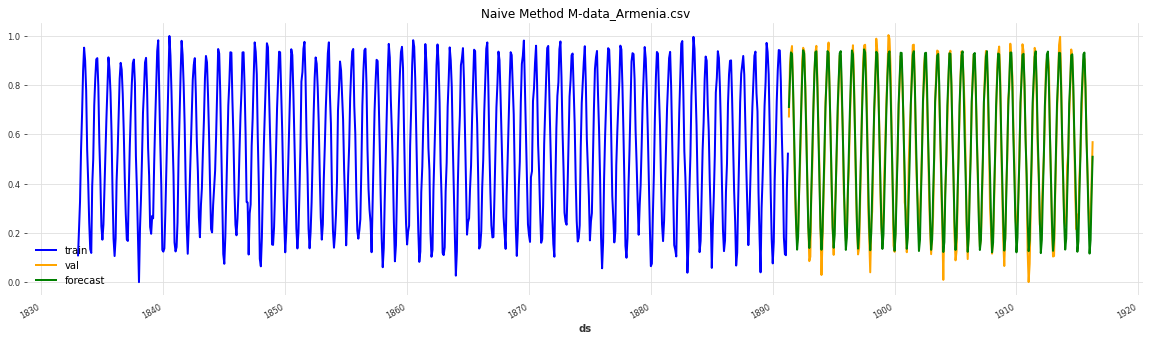

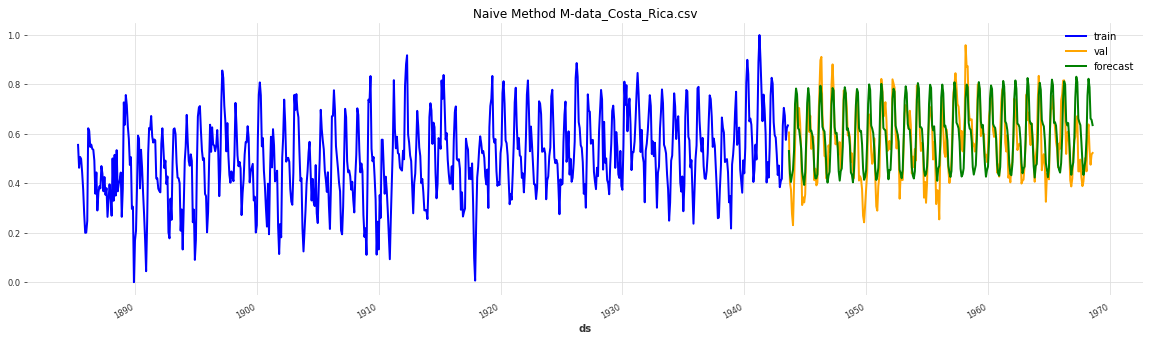

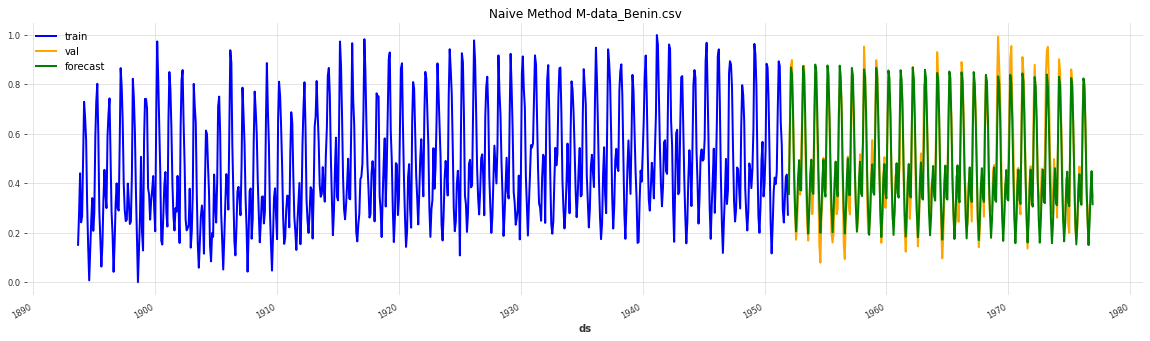

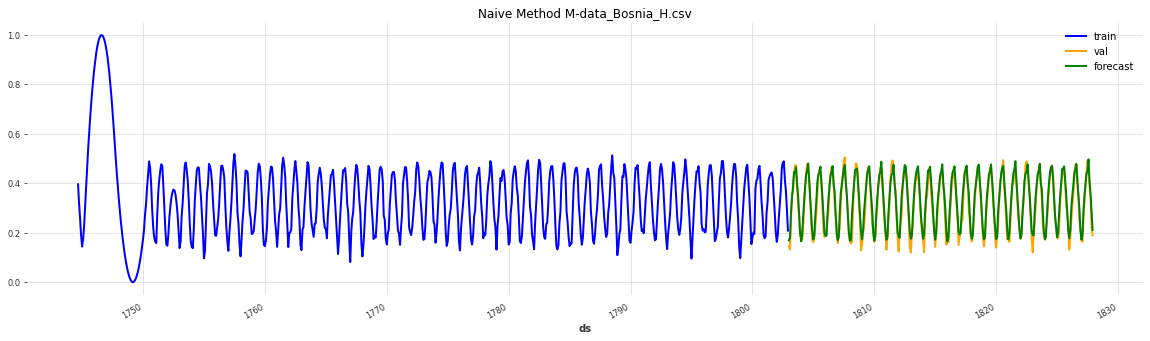

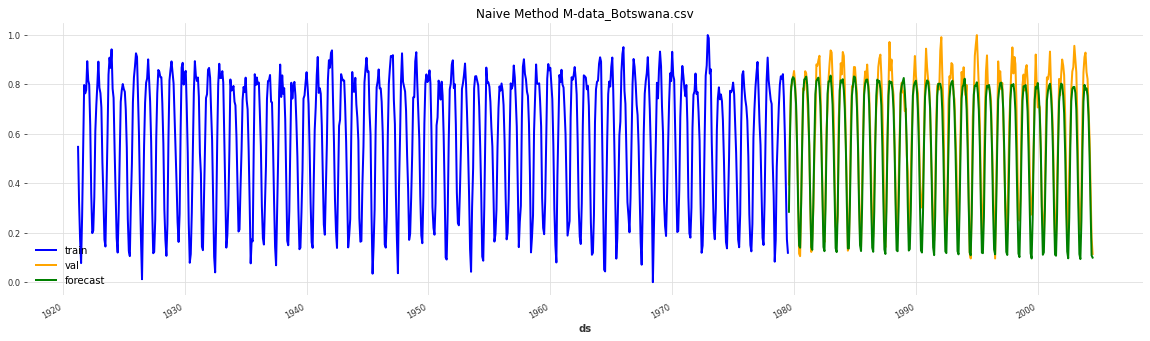

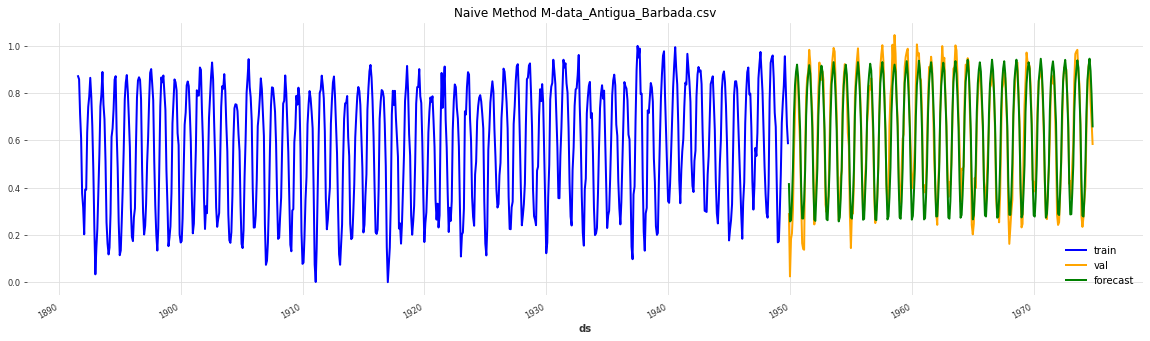

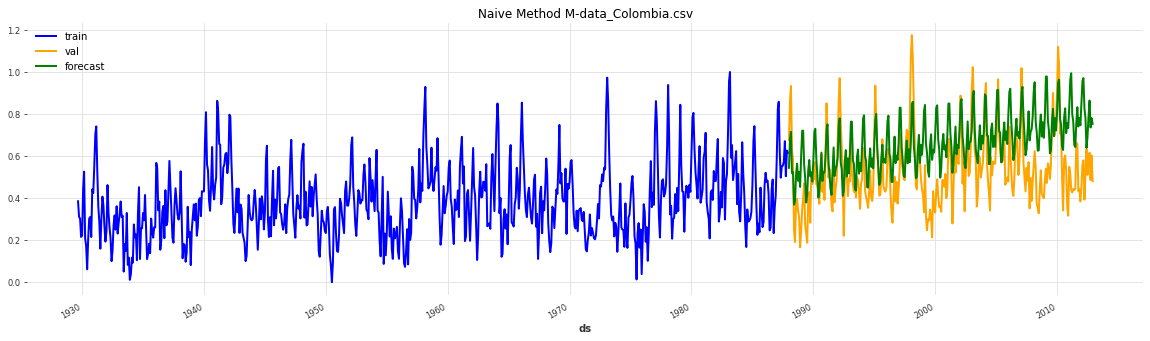

In [19]:
for i in range(len(df_fit_prophet)):
    plt.figure(figsize=(20,5))
    df_fit_prophet[i].plot(color ='blue', label="train")
    df_true_prediction_prophet[i].plot(color ='orange', label="val")
    forecast_prophet[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

In [20]:
for i in range(len(df_fit_naive)):
    if len(df_fit_naive[i]) != 700 :
        print("ERROR, len(df_fit_naive[{}]) = {}".format(i, len(df_fit_naive[i])))
    elif len(df_true_prediction_naive[i]) != 300 :
        print("ERROR, len(df_true_prediction_naive[{}]) = {}".format(i, len(df_true_prediction_naive[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
Tout est bon pour data i =  14
-----
Tout est bon pour data i =  15
-----
Tout est bon pour data i =  16
-----
Tout est bon pour data i =  17
-----
Tout est bon pour data i =  18
-----


In [21]:
for i in range(len(df_fit_prophet)):
    if len(df_fit_prophet[i]) != 700 :
        print("ERROR, len(df_fit_prophet[{}]) = {}".format(i, len(df_fit_prophet[i])))
    elif len(df_true_prediction_prophet[i]) != 300 :
        print("ERROR, len(df_true_prediction_prophet[{}]) = {}".format(i, len(df_true_prediction_prophet[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
Tout est bon pour data i =  14
-----
Tout est bon pour data i =  15
-----
Tout est bon pour data i =  16
-----
Tout est bon pour data i =  17
-----
Tout est bon pour data i =  18
-----
